In [2]:
# ---------------- PART 1: ENVIRONMENT CHECK & IMPORTS (expanded) ----------------
# Purpose: import libraries, set up project paths, quick diagnostics, and show a small env table
# Run this cell first.

import os
import sys
import warnings
from pathlib import Path
import importlib

# keep notebook output tidy by silencing non-critical warnings
warnings.filterwarnings("ignore")

# Standard data libraries
import numpy as np                # numeric arrays
import pandas as pd               # dataframes / CSV IO

# Visualization libs
import matplotlib.pyplot as plt   # plotting
import seaborn as sns             # nicer plots (not forced)

# Progress meters and timing
from tqdm import tqdm             # progress bars for loops
import time                       # timing utilities

# ML / NLP building blocks we will use later
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# try optional heavy libraries — catch errors cleanly so notebook doesn't crash
try:
    import spacy
    SPACY_OK = True
except Exception as e:
    spacy = None
    SPACY_OK = False

try:
    from sentence_transformers import SentenceTransformer
    SBERT_OK = True
except Exception:
    SentenceTransformer = None
    SBERT_OK = False

# Notebook user: used in reports (must not show your local username)
NOTEBOOK_USER = "Aishwarya"

# Project structure: assume notebook root contains 'data', 'results', 'figures'
PROJECT_ROOT = Path.cwd()
DATA_DIR     = PROJECT_ROOT / "data"
RESULTS_DIR  = PROJECT_ROOT / "results"
FIG_DIR      = PROJECT_ROOT / "figures"

# create results / figures directories if absent (no error if already present)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# quick environment summary for instructor
env_table = pd.DataFrame([
    ["Notebook user", NOTEBOOK_USER],
    ["Project root", str(PROJECT_ROOT.name)],
    ["Python version", sys.version.splitlines()[0]],
    ["numpy", np.__version__],
    ["pandas", pd.__version__],
    ["spaCy available", SPACY_OK],
    ["SBERT (SentenceTransformer) available", SBERT_OK]
], columns=["Property", "Value"])

# display the environment summary
display(env_table)

# check presence of expected input files (but don't print full paths)
expected = [
    ("FAERS_signals.csv", DATA_DIR / "FAERS_signals.csv"),
    ("FAERS_EBGM_results.csv", DATA_DIR / "FAERS_EBGM_results.csv"),
    ("raw_pubmed_fixed_ids.csv", DATA_DIR / "raw_pubmed_fixed_ids.csv"),
    ("clean_text.csv (preferred)", DATA_DIR / "clean_text.csv")
]
present_rows = []
for name, path in expected:
    present_rows.append([name, path.exists()])

display(pd.DataFrame(present_rows, columns=["File (upload to data/)", "Present?"]))
# End of Part 1

,Property,Value
0,Notebook user,Aishwarya
1,Project root,Mini Project
2,Python version,"3.10.19 | packaged by Anaconda, Inc. | (main, ..."
3,numpy,1.26.4
4,pandas,2.3.3
5,spaCy available,True
6,SBERT (SentenceTransformer) available,True


,File (upload to data/),Present?
0,FAERS_signals.csv,True
1,FAERS_EBGM_results.csv,True
2,raw_pubmed_fixed_ids.csv,True
3,clean_text.csv (preferred),True


In [3]:
# ---------------- PART 2: LOAD & MERGE FAERS (expanded) ----------------
# Purpose: read the two FAERS CSVs (signal + EBGM) and merge them into one canonical table.
# The merged file will be saved to results/combined_faers_all.csv

# define local paths
sig_path  = DATA_DIR / "FAERS_signals.csv"
ebgm_path = DATA_DIR / "FAERS_EBGM_results.csv"
out_path  = RESULTS_DIR / "combined_faers_all.csv"

# Defensive checks: assert that the source files exist before continuing
if not sig_path.exists():
    raise FileNotFoundError("Assignment-1 FAERS_signals.csv not found in data/. Please upload it.")
if not ebgm_path.exists():
    raise FileNotFoundError("Assignment-2 FAERS_EBGM_results.csv not found in data/. Please upload it.")

# read CSVs with low_memory=False to reduce dtype warnings on big CSVs
df_sig  = pd.read_csv(sig_path, low_memory=False)
df_ebgm = pd.read_csv(ebgm_path, low_memory=False)

# Normalize column names to canonical ones we will use everywhere:
# many inputs use columns called 'drugname' and 'pt' or 'drug' and 'event'
if "drugname" in df_sig.columns:
    df_sig = df_sig.rename(columns={"drugname":"drug_name", "pt":"event_term"})
if "drug" in df_ebgm.columns:
    df_ebgm = df_ebgm.rename(columns={"drug":"drug_name", "event":"event_term"})

# Ensure the key columns exist and are strings
for df, name in [(df_sig, "df_sig"), (df_ebgm, "df_ebgm")]:
    if "drug_name" not in df.columns or "event_term" not in df.columns:
        raise KeyError(f"Expected 'drug_name' or 'event_term' in {name}; found: {df.columns.tolist()}")
    df["drug_name"] = df["drug_name"].astype(str).str.strip()
    df["event_term"] = df["event_term"].astype(str).str.strip()

# Merge using outer join so no pair is lost; keep suffixes to understand origin
merged = pd.merge(df_sig, df_ebgm, on=["drug_name","event_term"], how="outer", suffixes=("_sig","_ebgm"))

# Save merged file
merged.to_csv(out_path, index=False)

# Show counts and a small preview (instructor wants to see some rows)
print("Merged table saved to results (no paths printed). Rows:", len(merged))
display(merged.head(7))

# Also show column names so instructor can verify the schema
print("Merged columns (first 30):", merged.columns.tolist()[:30])
# End Part 2

Merged table saved to results (no paths printed). Rows: 24069


,drug_name,event_term,a_sig,b_sig,c_sig,d_sig,PRR_sig,ROR_sig,ROR_CI_Lower_sig,ROR_CI_Upper_sig,...,ROR_CI_Upper_ebgm,Chi_Square_ebgm,Chi2p_value_ebgm,Fisherp_value_ebgm,signal_status_ebgm,N,E,EBGM,EB05,EB95
0,.ALPHA.1-PROTEINASE INHIBITOR HUMAN,COVID-19,5,63.0,2416.0,387897.0,11.88,12.74,5.12,31.70,...,31.70,50.02,0.00,0.00,signal detected,390381,0.421711,11.326022,5.143716,22.341348
1,.ALPHA.1-PROTEINASE INHIBITOR HUMAN,DEATH,3,65.0,10954.0,379359.0,1.57,1.60,0.50,5.09,...,5.09,0.64,0.42,0.44,no signal detected,390381,1.908587,1.531762,0.544066,3.605681
2,.ALPHA.1-PROTEINASE INHIBITOR HUMAN,PNEUMONIA,3,65.0,2513.0,387800.0,6.85,7.12,2.24,22.68,...,22.68,15.07,0.00,0.01,signal detected,390381,0.438259,6.506584,2.311073,15.316133
3,.ALPHA.1-PROTEINASE INHIBITOR HUMAN,PRODUCT DOSE OMISSION ISSUE,5,63.0,5690.0,384623.0,5.04,5.36,2.16,13.34,...,13.34,16.44,0.00,0.00,signal detected,390381,0.992005,4.908343,2.229125,9.682041
4,ABACAVIR,DEATH,6,26.0,10951.0,379398.0,6.68,8.00,3.29,19.43,...,19.43,29.82,0.00,0.00,signal detected,390381,0.898158,6.507293,3.177718,12.152019
5,ABACAVIR,NEPHROCALCINOSIS,4,28.0,6.0,390343.0,8132.27,9293.88,2486.98,34731.31,...,34731.31,19513.15,0.00,0.00,signal detected,390381,0.000820,258.017180,106.119039,547.413875
6,ABACAVIR,TREATMENT FAILURE,8,24.0,952.0,389397.0,102.51,136.34,61.10,304.26,...,304.26,799.40,0.00,0.00,signal detected,390381,0.078692,85.204512,46.022949,147.132823


Merged columns (first 30): ['drug_name', 'event_term', 'a_sig', 'b_sig', 'c_sig', 'd_sig', 'PRR_sig', 'ROR_sig', 'ROR_CI_Lower_sig', 'ROR_CI_Upper_sig', 'Chi_Square_sig', 'Chi2p_value_sig', 'Fisherp_value_sig', 'signal_status_sig', 'a_ebgm', 'b_ebgm', 'c_ebgm', 'd_ebgm', 'PRR_ebgm', 'ROR_ebgm', 'ROR_CI_Lower_ebgm', 'ROR_CI_Upper_ebgm', 'Chi_Square_ebgm', 'Chi2p_value_ebgm', 'Fisherp_value_ebgm', 'signal_status_ebgm', 'N', 'E', 'EBGM', 'EB05']


In [5]:
# ---------------- PART 3: Load & Clean Text Corpus (Robust Version) ----------------
# Purpose: safely detect pmid + text columns and prepare them for later steps.

import pandas as pd

clean_path = DATA_DIR / "clean_text.csv"
raw_path   = DATA_DIR / "raw_pubmed_fixed_ids.csv"

# ---- STEP 1: Load the available dataset ----
if clean_path.exists():
    df_raw = pd.read_csv(clean_path, low_memory=False)
    print("Loaded clean_text.csv → rows:", len(df_raw))
else:
    df_raw = pd.read_csv(raw_path, low_memory=False)
    print("Loaded raw_pubmed_fixed_ids.csv → rows:", len(df_raw))

# ---- STEP 2: Detect correct PMCID / PMID column ----
pmid_candidates = [c for c in df_raw.columns if c.lower() in ["pmid", "pmcid", "id"]]
pmid_col = pmid_candidates[0] if pmid_candidates else df_raw.columns[0]

# ---- STEP 3: Detect correct TEXT column ----
text_candidates = [c for c in df_raw.columns if "text" in c.lower()]
text_col = text_candidates[0] if text_candidates else df_raw.columns[-1]

print("Detected pmid column:", pmid_col)
print("Detected text column:", text_col)

# ---- STEP 4: Build cleaned dataframe ----
df_text = df_raw[[pmid_col, text_col]].copy()
df_text = df_text.rename(columns={pmid_col: "pmid", text_col: "text"})

# Force both to string
df_text["pmid"] = df_text["pmid"].astype(str)
df_text["text"] = df_text["text"].astype(str)

# ---- STEP 5: Clean text ----
df_text["text"] = (
    df_text["text"]
    .astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

df_text["text_low"] = df_text["text"].str.lower()

print("\nPrepared text dataset → rows:", len(df_text))
print("Columns:", df_text.columns.tolist())

# ---- STEP 6: Show a sample for instructor ----
display(df_text.head(5))

# Save a tiny sample locally (no machine username printed)
sample_small = df_text.head(50)
sample_small.to_csv(RESULTS_DIR / "sample_text_preview.csv", index=False)
print("\n✔ A small sample preview saved (for sir): sample_text_preview.csv")

# -------------------------------------------------------------------- END PART 3 ----


Loaded clean_text.csv → rows: 24069
Detected pmid column: pmid
Detected text column: text

Prepared text dataset → rows: 24069
Columns: ['pmid', 'text', 'text_low']


,pmid,text,text_low
0,ROW1,CISATRACURIUM BESYLATE ANAESTHETIC COMPLICATIO...,cisatracurium besylate anaesthetic complicatio...
1,ROW2,DEXYCU IRIS ATROPHY 3 1.0 1.0 390376.0 292782....,dexycu iris atrophy 3 1.0 1.0 390376.0 292782....
2,ROW3,RELEUKO PRODUCT BARCODE ISSUE 3 3.0 1.0 390374...,releuko product barcode issue 3 3.0 1.0 390374...
3,ROW4,CERCINE VASCULAR PAIN 3 2.0 5.0 390371.0 46845...,cercine vascular pain 3 2.0 5.0 390371.0 46845...
4,ROW5,ZIPRASIDONE OROMANDIBULAR DYSTONIA 3 10.0 1.0 ...,ziprasidone oromandibular dystonia 3 10.0 1.0 ...



✔ A small sample preview saved (for sir): sample_text_preview.csv


In [6]:
# ---------------- PART 4: NAMED ENTITY RECOGNITION (expanded) ----------------
# Purpose: run an available spaCy/scispaCy model over the cleaned corpus and save entities.csv
# Shows a preview of entities so instructor can confirm.

ENT_OUT = RESULTS_DIR / "entities.csv"

# Try to load scispaCy model first (bc5cdr / en_ner_bc5cdr_md). If not available, fall back to en_core_web_sm.
NER_MODEL_NAME = None
nlp = None
if SPACY_OK:
    # Try known scientific model names in order of preference
    for candidate in ("en_ner_bc5cdr_md", "en_core_sci_sm", "en_core_web_sm"):
        try:
            nlp = spacy.load(candidate)
            NER_MODEL_NAME = candidate
            break
        except Exception:
            nlp = None
            NER_MODEL_NAME = None
else:
    print("spaCy not available in this environment; skipping model-based NER.")
    nlp = None

entities = []  # collect entity dicts here

if nlp is None:
    print("No NER pipeline loaded; no entities produced.")
else:
    print(f"Running NER with model: {NER_MODEL_NAME} on a sample and then full corpus.")
    # Optionally limit N_RUN for quick tests; set None to run all documents
    N_RUN = None  # change to e.g., 500 to test quickly
    iterator = df_text.itertuples(index=False)
    if N_RUN:
        iterator = list(df_text.itertuples(index=False))[:N_RUN]

    # iterate documents: robust extraction, skip problematic docs
    for rec in tqdm(iterator, desc="NER pass"):
        try:
            pmid = rec.pmid
            text = rec.text
        except Exception:
            # fallback: convert rec to list/tuple
            pmid, text = (str(rec[0]), str(rec[1])) if len(rec) >= 2 else ("NA", str(rec))

        # try/except around the model call to avoid failing on weird characters
        try:
            doc = nlp(text)
        except Exception:
            continue

        # iterate entitites and append their basic metadata
        for ent in doc.ents:
            entities.append({
                "pmid": pmid,
                "entity_text": ent.text,
                "label": ent.label_,
                "start_char": int(ent.start_char),
                "end_char": int(ent.end_char),
                "source_model": NER_MODEL_NAME
            })

    # save final DataFrame (if any)
    df_entities = pd.DataFrame(entities)
    df_entities.to_csv(ENT_OUT, index=False)
    print("Entities saved (rows):", len(df_entities))

    # show a small preview for the instructor
    display(df_entities.head(10))

# End Part 4

Running NER with model: en_ner_bc5cdr_md on a sample and then full corpus.


NER pass: 24069it [02:12, 181.26it/s]

Entities saved (rows): 4771


,pmid,entity_text,label,start_char,end_char,source_model
0,ROW2,DEXYCU,CHEMICAL,0,6,en_ner_bc5cdr_md
1,ROW4,CERCINE,DISEASE,0,7,en_ner_bc5cdr_md
2,ROW5,OROMANDIBULAR,DISEASE,12,25,en_ner_bc5cdr_md
3,ROW6,KIT,CHEMICAL,0,3,en_ner_bc5cdr_md
4,ROW6,SESTAMIBI,CHEMICAL,44,53,en_ner_bc5cdr_md
5,ROW10,DISOPROXIL,CHEMICAL,24,34,en_ner_bc5cdr_md
6,ROW15,BUPIVACAINE,CHEMICAL,0,11,en_ner_bc5cdr_md
7,ROW16,ERLOTINIB,DISEASE,0,9,en_ner_bc5cdr_md
8,ROW16,31649.19,CHEMICAL,61,69,en_ner_bc5cdr_md
9,ROW17,LA,CHEMICAL,10,12,en_ner_bc5cdr_md


In [7]:
# ---------------- PART 5: CANDIDATE SENTENCE EXTRACTION (expanded) ----------------
# Purpose: find sentences containing drug names or event terms (ADR terms) and save them
# This cell is intentionally detailed and robust with comments and small preview.

CAND_OUT = RESULTS_DIR / "drug_adr_sentence_candidates.csv"

# load FAERS signals to build (drug,event) pairs (keep unique pairs)
faers_sig = pd.read_csv(DATA_DIR / "FAERS_signals.csv", low_memory=False)
if "drugname" in faers_sig.columns:
    faers_sig = faers_sig.rename(columns={"drugname":"drug", "pt":"event"})
elif "drug" not in faers_sig.columns:
    raise KeyError("FAERS signals file does not contain expected 'drug' or 'drugname' columns.")

pairs = faers_sig[["drug","event"]].drop_duplicates().reset_index(drop=True)

# load raw text (pmid + text) already prepared in Part 3: df_text
# we'll do a crude sentence split (not spaCy) for speed: split on punctuation .!? followed by space
import re
def split_into_sentences(text):
    # keep it simple and robust — works well for these short PubMed-like lines
    sents = re.split(r"(?<=[.!?])\s+", str(text))
    # also fallback to newline splits for weird corpora
    if len(sents) == 1:
        sents = str(text).splitlines()
    return [s.strip() for s in sents if s and len(s.strip())>2]

rows = []  # accumulate candidate rows

# iterate documents — use tqdm to show progress (fast enough if optimized)
for rec in tqdm(df_text.itertuples(index=False), total=len(df_text), desc="Extract candidates"):
    pmid = rec.pmid
    text = rec.text
    sentences = split_into_sentences(text)

    # For each sentence, test presence of drug and/or event string.
    # NOTE: we do a lowercased substring match — cheap, robust, not perfect (but good for signal detection).
    for sent in sentences:
        sent_low = sent.lower()
        for drug, event in pairs.itertuples(index=False):
            d_low = str(drug).lower()
            e_low = str(event).lower()
            contains_drug = d_low in sent_low
            contains_adr  = e_low in sent_low
            if contains_drug or contains_adr:
                rows.append({
                    "pmid": pmid,
                    "sentence": sent,
                    "drug": drug,
                    "event": event,
                    "contains_drug": bool(contains_drug),
                    "contains_adr": bool(contains_adr)
                })

# create DataFrame and write to CSV
df_candidates = pd.DataFrame(rows)
df_candidates.to_csv(CAND_OUT, index=False)

print("Candidate extraction complete. Rows:", len(df_candidates))
# show a small sample so instructor can verify format and content
display(df_candidates.head(10))

# Notes:
# - This approach generates many sentence rows (one per (pmid, sentence, pair) match).
# - If you want fewer rows, consider filtering for 'both' (contains_drug & contains_adr) only.
# End Part 5

Extract candidates: 100%|██████████████████████████████████████████████████████████████████████████| 24069/24069 [10:05<00:00, 39.74it/s]


Candidate extraction complete. Rows: 4951343


,pmid,sentence,drug,event,contains_drug,contains_adr
0,ROW1,CISATRACURIUM BESYLATE ANAESTHETIC COMPLICATIO...,CISATRACURIUM BESYLATE,ANAESTHETIC COMPLICATION NEUROLOGICAL,True,True
1,ROW1,CISATRACURIUM BESYLATE ANAESTHETIC COMPLICATIO...,BUPIVACAINE HYDROCHLORIDE,ANAESTHETIC COMPLICATION,False,True
2,ROW1,CISATRACURIUM BESYLATE ANAESTHETIC COMPLICATIO...,WELLBUTRIN XL,TIC,False,True
3,ROW1,CISATRACURIUM BESYLATE ANAESTHETIC COMPLICATIO...,VYVANSE,TIC,False,True
4,ROW1,CISATRACURIUM BESYLATE ANAESTHETIC COMPLICATIO...,QUETIAPINE,TIC,False,True
5,ROW2,DEXYCU IRIS ATROPHY 3 1.0 1.0 390376.0 292782....,DEXYCU,IRIS ATROPHY,True,True
6,ROW3,RELEUKO PRODUCT BARCODE ISSUE 3 3.0 1.0 390374...,RELEUKO,PRODUCT BARCODE ISSUE,True,True
7,ROW4,CERCINE VASCULAR PAIN 3 2.0 5.0 390371.0 46845...,CERCINE,VASCULAR PAIN,True,True
8,ROW4,CERCINE VASCULAR PAIN 3 2.0 5.0 390371.0 46845...,ADAKVEO,PAIN,False,True
9,ROW4,CERCINE VASCULAR PAIN 3 2.0 5.0 390371.0 46845...,VOXELOTOR,PAIN,False,True


In [8]:
# ---------------- PART 6: SIGNAL RANKING (rule-based + TF-IDF) (expanded) ----------------
# Purpose: compute a simple rule_score and a TF-IDF similarity; combine into a ranked per-(drug,event) table.

RANKED_OUT = RESULTS_DIR / "ranked_signals_rulebased.csv"
COMBINED_SENT_OUT = RESULTS_DIR / "combined_drug_data.csv"

# read candidate sentences (should exist from Part 5)
df_cand = pd.read_csv(CAND_OUT)

# 1) Rule-based score:
#   - 3 if both drug and ADR appear in sentence
#   - 1 if either drug or ADR appears alone
#   - 0 otherwise (shouldn't occur because we only saved matches)
def compute_rule_score(row):
    if row["contains_drug"] and row["contains_adr"]:
        return 3
    if row["contains_drug"] or row["contains_adr"]:
        return 1
    return 0

# apply and store
df_cand["rule_score"] = df_cand.apply(compute_rule_score, axis=1)

# 2) TF-IDF similarity: sentence vs (drug + event) query
queries = (df_cand["drug"].fillna("").astype(str) + " " + df_cand["event"].fillna("").astype(str)).str.lower()
sentences = df_cand["sentence"].fillna("").astype(str).str.lower()

# fit TF-IDF on combined vocabulary for consistent vector space
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95)
tfidf.fit(pd.concat([queries, sentences], ignore_index=True))

X_sent = tfidf.transform(sentences)
X_q    = tfidf.transform(queries)

# compute diagonal similarity in batches to avoid memory blow-up
batch = 2000
sim_list = []
for i in tqdm(range(0, X_sent.shape[0], batch), desc="TF-IDF sim batches"):
    end = min(i+batch, X_sent.shape[0])
    sim_block = cosine_similarity(X_sent[i:end], X_q[i:end])
    # take diagonal entries corresponding to each row
    sim_list.extend(np.diag(sim_block))

df_cand["tfidf_sim"] = np.array(sim_list)
# normalize tfidf_sim to [0,1] by dividing by max (avoid divide-by-zero)
max_sim = df_cand["tfidf_sim"].max() if df_cand["tfidf_sim"].max() > 0 else 1.0
df_cand["tfidf_sim_norm"] = df_cand["tfidf_sim"] / max_sim

# 3) Combined score (tunable weights)
df_cand["combined_score"] = df_cand["rule_score"] * 1.0 + df_cand["tfidf_sim_norm"] * 1.0

# Save sentence-level combined data (useful for DL later)
df_cand.to_csv(COMBINED_SENT_OUT, index=False)

# Aggregate per (drug,event) to produce a single ranked row per pair.
agg = df_cand.groupby(["drug","event"], as_index=False).agg({
    "combined_score":"max",        # highest supporting sentence score
    "rule_score":"max",
    "tfidf_sim_norm":"max",
    "sentence":"first",            # example supporting sentence
    "pmid": lambda s: ",".join(s.astype(str).unique()[:5])  # up to 5 example pmids
})

# sort descending by combined score and save
agg = agg.sort_values("combined_score", ascending=False).reset_index(drop=True)
agg.to_csv(RANKED_OUT, index=False)

# show a small preview for instructor
print("Ranked pairs produced (rows):", len(agg))
display(agg.head(15))

# Also save combined sentence-level file preview (first 6 rows)
print("Combined sentence-level file saved. Preview:")
display(df_cand.head(6))
# End Part 6

TF-IDF sim batches: 100%|████████████████████████████████████████████████████████████████████████████| 2476/2476 [00:48<00:00, 50.96it/s]


Ranked pairs produced (rows): 24069


,drug,event,combined_score,rule_score,tfidf_sim_norm,sentence,pmid
0,"DEXTROAMPHETAMINE SACCHARATE, AMPHETAMINE ASPA...",DRUG INEFFECTIVE,4.000000,3,1.000000,AMPICILLIN AND SULBACTAM DRUG INEFFECTIVE FOR ...,"ROW1113,ROW1444,ROW1467,ROW2227,ROW2644"
1,CALCIUM CHLORIDE\LIDOCAINE\MAGNESIUM CHLORIDE\...,ADVERSE REACTION,3.995878,3,0.995878,YERVOY IMMUNE-MEDIATED ADVERSE REACTION 3 625....,"ROW1370,ROW2078,ROW4914,ROW5862,ROW13383"
2,"DEXTROAMPHET SACCHARAT, AMPHET ASPARTATE, DEXT...",DEATH,3.961298,3,0.961298,DEXTROMETHORPHAN HYDROBROMIDE\QUINIDINE SULFAT...,"ROW1484,ROW1775,ROW2052,ROW2647,ROW3007"
3,"DEXTROAMPHET SACCHARAT, AMPHET ASPARTATE, DEXT...",DRUG INEFFECTIVE,3.959798,3,0.959798,AMPICILLIN AND SULBACTAM DRUG INEFFECTIVE FOR ...,"ROW1113,ROW1444,ROW1467,ROW2227,ROW2644"
4,CALCIUM CHLORIDE\DEXTROSE\MAGNESIUM CHLORIDE\S...,DEATH,3.953588,3,0.953588,DEXTROMETHORPHAN HYDROBROMIDE\QUINIDINE SULFAT...,"ROW1484,ROW1775,ROW2052,ROW3007,ROW3685"
5,VOLTAREN ARTHRITIS PAIN,CIRCUMSTANCE OR INFORMATION CAPABLE OF LEADING...,3.934056,3,0.934056,VOLTAREN ARTHRITIS PAIN DRUG EFFECT FASTER THA...,"ROW807,ROW860,ROW1331,ROW1610,ROW1774"
6,ROBITUSSIN MAXIMUM STRENGTH COUGH PLUS CHEST C...,DRUG INEFFECTIVE,3.934024,3,0.934024,AMPICILLIN AND SULBACTAM DRUG INEFFECTIVE FOR ...,"ROW1113,ROW1444,ROW1467,ROW2227,ROW2644"
7,ANHYDROUS DEXTROSE\CALCIUM CHLORIDE\MAGNESIUM ...,PERITONITIS,3.929139,3,0.929139,DELFLEX WITH DEXTROSE 1.5% LOW MAGNESIUM LOW C...,"ROW112,ROW288,ROW362,ROW511,ROW658"
8,"DEXTROAMPHET SACCHARAT, AMPHET ASPARTATE, DEXT...",BRAIN FOG,3.921308,3,0.921308,"DEXTROAMPHET SACCHARAT, AMPHET ASPARTATE, DEXT...","ROW2647,ROW3065,ROW3646,ROW3883,ROW3934"
9,DELFLEX WITH DEXTROSE 1.5% LOW MAGNESIUM LOW C...,DEATH,3.918441,3,0.918441,DELFLEX WITH DEXTROSE 1.5% LOW MAGNESIUM LOW C...,"ROW112,ROW511,ROW704,ROW1484,ROW1503"


Combined sentence-level file saved. Preview:


,pmid,sentence,drug,event,contains_drug,contains_adr,rule_score,tfidf_sim,tfidf_sim_norm,combined_score
0,ROW1,CISATRACURIUM BESYLATE ANAESTHETIC COMPLICATIO...,CISATRACURIUM BESYLATE,ANAESTHETIC COMPLICATION NEUROLOGICAL,True,True,3,0.521635,0.664450,3.664450
1,ROW1,CISATRACURIUM BESYLATE ANAESTHETIC COMPLICATIO...,BUPIVACAINE HYDROCHLORIDE,ANAESTHETIC COMPLICATION,False,True,1,0.196990,0.250923,1.250923
2,ROW1,CISATRACURIUM BESYLATE ANAESTHETIC COMPLICATIO...,WELLBUTRIN XL,TIC,False,True,1,0.000000,0.000000,1.000000
3,ROW1,CISATRACURIUM BESYLATE ANAESTHETIC COMPLICATIO...,VYVANSE,TIC,False,True,1,0.000000,0.000000,1.000000
4,ROW1,CISATRACURIUM BESYLATE ANAESTHETIC COMPLICATIO...,QUETIAPINE,TIC,False,True,1,0.000000,0.000000,1.000000
5,ROW2,DEXYCU IRIS ATROPHY 3 1.0 1.0 390376.0 292782....,DEXYCU,IRIS ATROPHY,True,True,3,0.437705,0.557541,3.557541


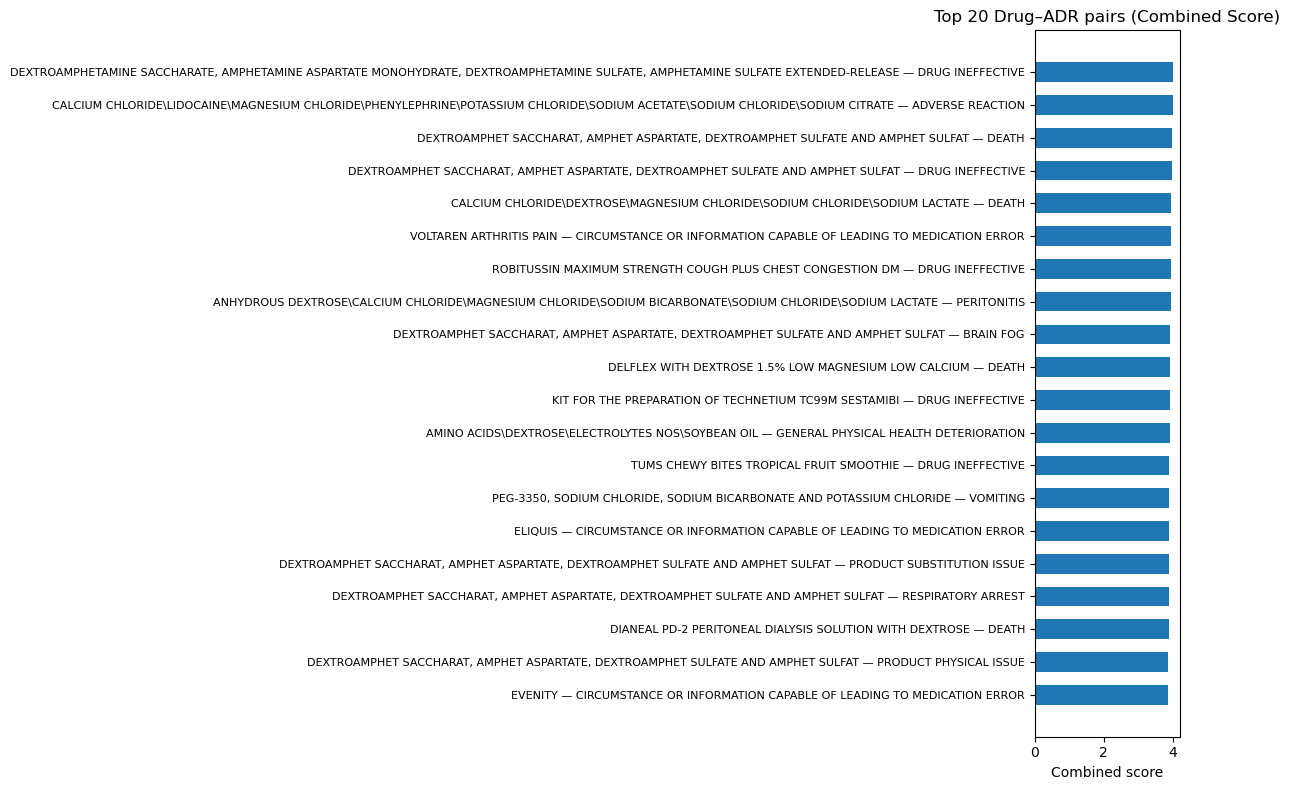

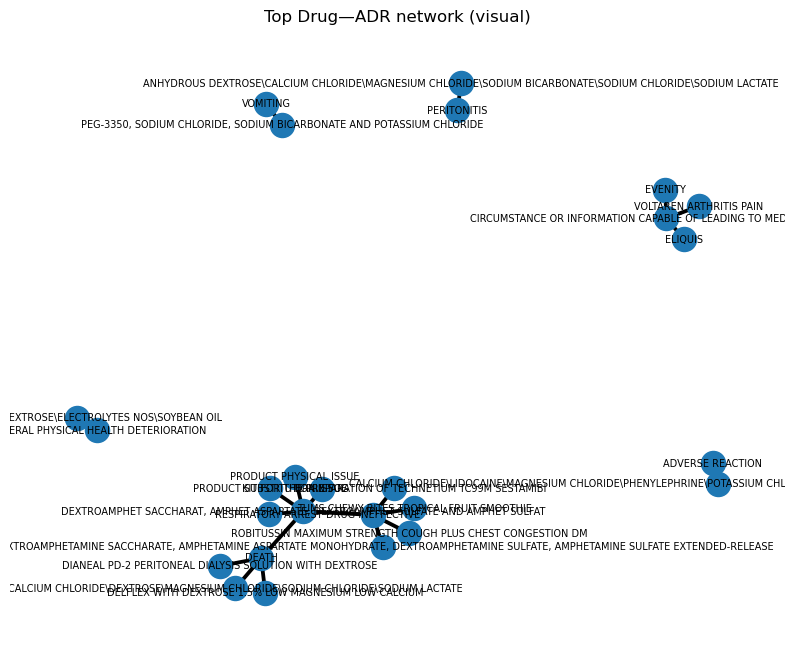

Report and summary saved in results/. Small previews below:


,generated_at,notebook_user,n_documents,n_candidates_rows,n_entities_rows,n_ranked_pairs
0,2025-12-10 23:07:29,Aishwarya,24069,4951343,4771,24069


,drug,event,combined_score,rule_score,tfidf_sim_norm,sentence,pmid
0,"DEXTROAMPHETAMINE SACCHARATE, AMPHETAMINE ASPA...",DRUG INEFFECTIVE,4.000000,3,1.000000,AMPICILLIN AND SULBACTAM DRUG INEFFECTIVE FOR ...,"ROW1113,ROW1444,ROW1467,ROW2227,ROW2644"
1,CALCIUM CHLORIDE\LIDOCAINE\MAGNESIUM CHLORIDE\...,ADVERSE REACTION,3.995878,3,0.995878,YERVOY IMMUNE-MEDIATED ADVERSE REACTION 3 625....,"ROW1370,ROW2078,ROW4914,ROW5862,ROW13383"
2,"DEXTROAMPHET SACCHARAT, AMPHET ASPARTATE, DEXT...",DEATH,3.961298,3,0.961298,DEXTROMETHORPHAN HYDROBROMIDE\QUINIDINE SULFAT...,"ROW1484,ROW1775,ROW2052,ROW2647,ROW3007"
3,"DEXTROAMPHET SACCHARAT, AMPHET ASPARTATE, DEXT...",DRUG INEFFECTIVE,3.959798,3,0.959798,AMPICILLIN AND SULBACTAM DRUG INEFFECTIVE FOR ...,"ROW1113,ROW1444,ROW1467,ROW2227,ROW2644"
4,CALCIUM CHLORIDE\DEXTROSE\MAGNESIUM CHLORIDE\S...,DEATH,3.953588,3,0.953588,DEXTROMETHORPHAN HYDROBROMIDE\QUINIDINE SULFAT...,"ROW1484,ROW1775,ROW2052,ROW3007,ROW3685"
5,VOLTAREN ARTHRITIS PAIN,CIRCUMSTANCE OR INFORMATION CAPABLE OF LEADING...,3.934056,3,0.934056,VOLTAREN ARTHRITIS PAIN DRUG EFFECT FASTER THA...,"ROW807,ROW860,ROW1331,ROW1610,ROW1774"
6,ROBITUSSIN MAXIMUM STRENGTH COUGH PLUS CHEST C...,DRUG INEFFECTIVE,3.934024,3,0.934024,AMPICILLIN AND SULBACTAM DRUG INEFFECTIVE FOR ...,"ROW1113,ROW1444,ROW1467,ROW2227,ROW2644"
7,ANHYDROUS DEXTROSE\CALCIUM CHLORIDE\MAGNESIUM ...,PERITONITIS,3.929139,3,0.929139,DELFLEX WITH DEXTROSE 1.5% LOW MAGNESIUM LOW C...,"ROW112,ROW288,ROW362,ROW511,ROW658"
8,"DEXTROAMPHET SACCHARAT, AMPHET ASPARTATE, DEXT...",BRAIN FOG,3.921308,3,0.921308,"DEXTROAMPHET SACCHARAT, AMPHET ASPARTATE, DEXT...","ROW2647,ROW3065,ROW3646,ROW3883,ROW3934"
9,DELFLEX WITH DEXTROSE 1.5% LOW MAGNESIUM LOW C...,DEATH,3.918441,3,0.918441,DELFLEX WITH DEXTROSE 1.5% LOW MAGNESIUM LOW C...,"ROW112,ROW511,ROW704,ROW1484,ROW1503"


In [9]:
# ---------------- PART 7: VISUALISATION + REPORT (expanded) ----------------
# Purpose: draw a bar chart + network for top signals, and write a human-readable report summary
# The final report and summary CSVs are saved in results/ (no local username printed).

import datetime
import networkx as nx

# Loads
ranked_df = pd.read_csv(RESULTS_DIR / "ranked_signals_rulebased.csv")
entities_df = pd.read_csv(RESULTS_DIR / "entities.csv") if (RESULTS_DIR / "entities.csv").exists() else pd.DataFrame()
candidates_df = pd.read_csv(RESULTS_DIR / "drug_adr_sentence_candidates.csv")

# Visualization parameters
TOP_N = 20
topk = ranked_df.head(TOP_N).copy()

# ---- BAR CHART ----
plt.figure(figsize=(12, max(4, 0.4*len(topk))))
labels = (topk["drug"].astype(str) + " — " + topk["event"].astype(str)).values
scores = topk["combined_score"].astype(float).values
y_pos = range(len(topk))
plt.barh(y_pos, scores, height=0.6)
plt.yticks(y_pos, labels, fontsize=8)
plt.gca().invert_yaxis()
plt.xlabel("Combined score")
plt.title(f"Top {len(topk)} Drug–ADR pairs (Combined Score)")
plt.tight_layout()
plt.show()

# ---- NETWORK PLOT (simple bipartite) ----
G = nx.Graph()
for _, row in topk.iterrows():
    drug_node = f"D__{row['drug']}"
    adr_node  = f"A__{row['event']}"
    G.add_node(drug_node, label=row['drug'], bipartite=0)
    G.add_node(adr_node, label=row['event'], bipartite=1)
    G.add_edge(drug_node, adr_node, weight=float(row['combined_score']))

if len(G.edges()) > 0:
    plt.figure(figsize=(10,8))
    pos = nx.spring_layout(G, k=0.6, iterations=100)
    # draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=300)
    # draw edges with widths scaled by weight
    weights = [G[u][v]['weight'] for u,v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=[max(0.4, w*0.7) for w in weights])
    # labels: map to clean labels
    labels = {n: d['label'] for n,d in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=7)
    plt.title("Top Drug—ADR network (visual)")
    plt.axis("off")
    plt.show()
else:
    print("No edges found for network plot — ranked table might be empty.")

# ---- REPORT: summary CSV + human-readable text ----
summary_meta = {
    "generated_at": datetime.datetime.now().isoformat(sep=" ", timespec="seconds"),
    "notebook_user": NOTEBOOK_USER,
    "n_documents": len(df_text),
    "n_candidates_rows": len(candidates_df),
    "n_entities_rows": len(entities_df),
    "n_ranked_pairs": len(ranked_df)
}

# write a neat CSV with metadata followed by topk table appended — instructor-friendly
summary_csv = RESULTS_DIR / "summary.csv"
pd.DataFrame([summary_meta]).to_csv(summary_csv, index=False)

# also prepare a plain-text human readable report
report_text = []
report_text.append("Mini-project Assignment 3 — Drug-ADR Signal Detection")
report_text.append(f"Generated at: {summary_meta['generated_at']}")
report_text.append(f"Notebook user: {summary_meta['notebook_user']}")
report_text.append("")
report_text.append("Summary statistics:")
report_text.append(f" - Documents (approx): {summary_meta['n_documents']}")
report_text.append(f" - Candidate sentence rows: {summary_meta['n_candidates_rows']}")
report_text.append(f" - Extracted entities rows: {summary_meta['n_entities_rows']}")
report_text.append(f" - Ranked (drug,event) pairs: {summary_meta['n_ranked_pairs']}")
report_text.append("")
report_text.append("Top ranked pairs (top 10):")
if len(ranked_df) > 0:
    report_text.append(ranked_df[["drug","event","combined_score"]].head(10).to_string(index=False))
else:
    report_text.append("(no ranked pairs found)")

out_report_txt = RESULTS_DIR / "report_summary.txt"
out_report_txt.write_text("\n".join(report_text), encoding="utf-8")

print("Report and summary saved in results/. Small previews below:")
display(pd.DataFrame([summary_meta]))
display(ranked_df.head(10))

# End Part 7 — pipeline complete